<div>
    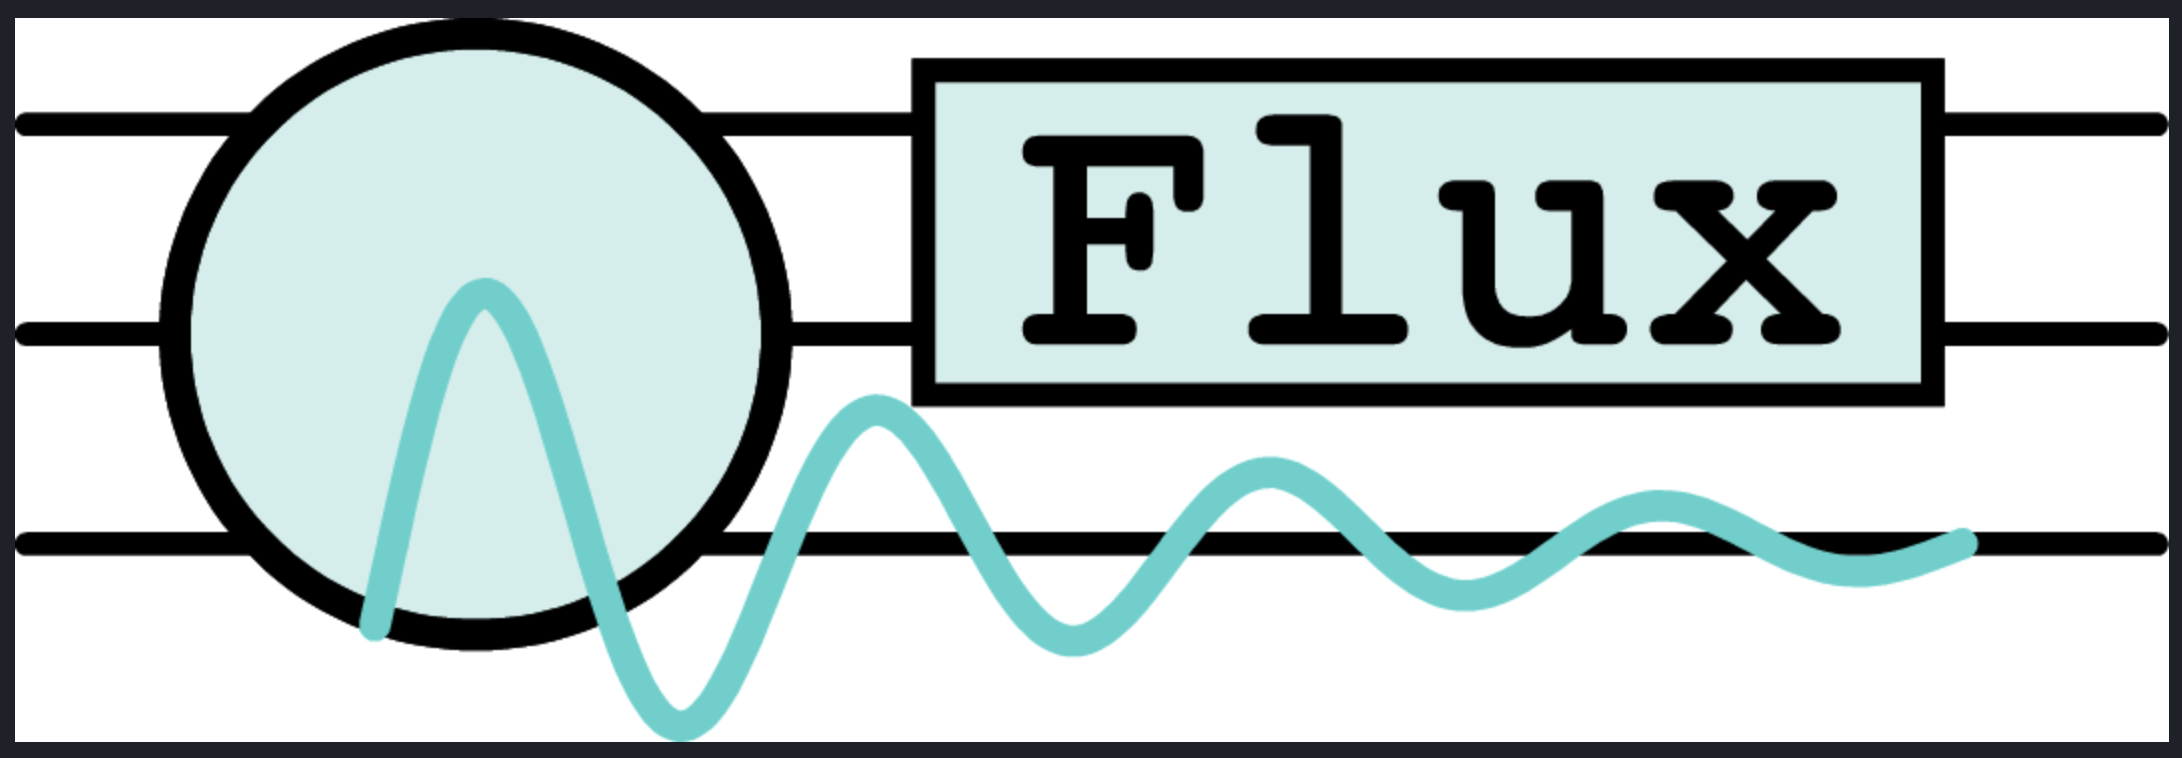
</div>

# Installation: Run the following cell to install QFlux in Colab

In [ ]:
!pip install qflux[gqme]

# **QFlux Tutorial**

<h2> This notebook implements codes referenced in the Supporting Information for: </h2>

<h2>
<b> QFlux: Quantum Circuit Implementations for Molecular Dynamics </b>
</h2>

<h2> <b> Part VI - The Generalized Quantum Master Equation</b> </h2>

<h3>
    <b> Authors: </b> <br><br>
Xiaohan Dan, Pouya Khazaei, Ningyi Lyu, Callie Wilson, Ellen Mulvihill, Yuchen Wang, Brandon C. Allen, Delmar G. A. Cabral, Saurabh Shivpuje, Sabre Kais, Victor S. Batista, and Eitan Geva</h3>

**Note:** Each section builds on the previous ones. **Execute the cells sequentially**, as later sections rely on functions and data defined earlier.

# Table of Contents

* Section 1

  - <a href="#ScriptSpt1pt1">Script S.1.1: Spin--Boson Model Parameters</a>

  - <a href="#ScriptSpt1pt2">Script S.1.2: Using TT-TFD To Simulate The Spin--Boson Model</a>

* Section 2

  - <a href="#ScriptSpt2pt1">Script S.2.1: Projected Liouvillian</a>

  - <a href="#ScriptSpt2pt2">Script S.2.2: The Dynamics With Projected Liouvillian Only</a>

* Section 3

  - <a href="#ScriptSpt3pt1">Script S.3.1: Using QFlux To Obtain The Memory Kernel</a>

  - <a href="#ScriptSpt3pt2">Script S.3.2: The Propagator</a>

  - <a href="#ScriptSpt3pt3">Script S.3.3: Projection-Free Inputs $ {\cal F}(\tau) $ And $ \dot{\cal F}(\tau) $</a>

  - <a href="#ScriptSpt3pt4">Script S.3.4: Linear Term $ g(t) $</a>

  - <a href="#ScriptSpt3pt5">Script S.3.5: Memory Kernel - Volterra Algorithm</a>

  - <a href="#ScriptSpt3pt6">Script S.3.6: Function To Calculate Integral Via Trapezoidal Rule</a>

  - <a href="#ScriptSpt3pt7">Script S.3.7: Plot The Memory Kernel</a>

* Section 4

  - <a href="#ScriptSpt4pt1">Script S.4.1: Solve GQME Through QFlux</a>

  - <a href="#ScriptSpt4pt2">Script S.4.2: GQME - Propagation Via RK4 Method</a>

  - <a href="#ScriptSpt4pt3">Script S.4.3: Calculating The Function $ f $</a>

  - <a href="#ScriptSpt4pt4">Script S.4.4: GQME - Propagation Of The Density Matrix</a>

* Section 5

  - <a href="#ScriptSpt5pt1">Script S.5.1: Calculating $ {\cal{G}}(t) $ by solving the GQME</a>

  - <a href="#ScriptSpt5pt2">Script S.5.2: Dilation Of The Non-Unitary Propagator</a>

  - <a href="#ScriptSpt5pt3">Script S.5.3: Using QFlux To Perform Quantum Algorithm For GQME</a>

* Section 6

  - <a href="#ScriptSpt6pt1">Script S.6.1: Installing And Importing Qiskit Dependencies</a>

  - <a href="#ScriptSpt6pt2">Script S.6.2: Qasm  Simulation For GQME</a>

  - <a href="#ScriptSpt6pt3">Script S.6.3: Visualizing The Results</a>

# Download the precomputed data files

In [2]:
# Download the precomputed trajectory data files from the qflux GitHub repository https://github.com/batistagroup/qflux
# to the local folder ./data/GQME_example

from qflux.utils.io import download_github_directory

# directory for precomputed trajectory data files (adjust if needed)
data_dir = 'GQME_Example_data'
download_github_directory('batistagroup', 'qflux', 'data/GQME_Example', data_dir)


===> Directory: data/GQME_Example/GQME_Output
Downloading: GQME_Example_data/GQME_Output/Sigma_00_Spin-Boson_Ohmic_TT-TFD_b5G1_e1_xi0.1wc2_wmax10_dofn50.txt
Downloading: GQME_Example_data/GQME_Output/Sigma_01_Spin-Boson_Ohmic_TT-TFD_b5G1_e1_xi0.1wc2_wmax10_dofn50.txt
Downloading: GQME_Example_data/GQME_Output/Sigma_10_Spin-Boson_Ohmic_TT-TFD_b5G1_e1_xi0.1wc2_wmax10_dofn50.txt
Downloading: GQME_Example_data/GQME_Output/Sigma_11_Spin-Boson_Ohmic_TT-TFD_b5G1_e1_xi0.1wc2_wmax10_dofn50.txt
===> Directory: data/GQME_Example/K_Output
Downloading: GQME_Example_data/K_Output/K_0000_Spin-Boson_Ohmic_TT-TFD_b5G1_e1_xi0.1wc2_wmax10_dofn50.txt
Downloading: GQME_Example_data/K_Output/K_0001_Spin-Boson_Ohmic_TT-TFD_b5G1_e1_xi0.1wc2_wmax10_dofn50.txt
Downloading: GQME_Example_data/K_Output/K_0010_Spin-Boson_Ohmic_TT-TFD_b5G1_e1_xi0.1wc2_wmax10_dofn50.txt
Downloading: GQME_Example_data/K_Output/K_0011_Spin-Boson_Ohmic_TT-TFD_b5G1_e1_xi0.1wc2_wmax10_dofn50.txt
Downloading: GQME_Example_data/K_Output/K_0

# Import the standard packages

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# Section 1

## Script S.1.1: Spin--Boson Model Parameters <a name="ScriptSpt1pt1"></a>

In [4]:
GAMMA_DA = 1.0   # diabatic coupling
EPSILON = 1.0    # energy bias
BETA = 5.0       # inverse temperature
XI = 0.1         # Kondo parameter
OMEGA_C = 2.0    # cutoff frequency


## Script S.1.2: Using TT-TFD To Simulate The Spin--Boson Model <a name="ScriptSpt1pt2"></a>

SPIN-BOSON Model parameter
        epsilon = 1
             xi = 0.1
        omega_c = 2
      omega_max = 10
     time steps = 500
             DT = 0.00600331998021117
     final time = 3.001659990105585
          DOF_E = 2
          DOF_N = 50


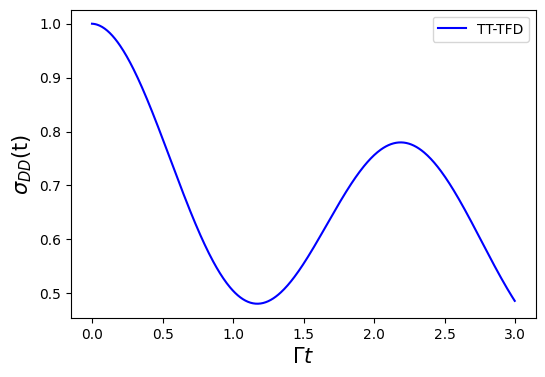

In [5]:
from qflux.GQME.dynamics_GQME import DynamicsGQME
import qflux.GQME.tt_tfd as tfd
import qflux.GQME.params as pa
import qflux.GQME.readwrite as wr

#============setup the Hamiltonian and initial state for Spin-Boson Model
Hsys = pa.EPSILON*pa.Z + pa.GAMMA_DA*pa.X
rho0 = np.zeros((pa.DOF_E,pa.DOF_E),dtype=np.complex128)
rho0[0,0] = 1.0

#Create the Spin-Boson model (SBM)
SBM = DynamicsGQME(pa.DOF_E,Hsys,rho0)
SBM.setup_timestep(pa.DT, pa.TIME_STEPS)

#== The TT-TFD simulation (may take significant computational time).

# Is_run_dynamics = True  -- Trajectories will be computed and the data will be written to `data_dir`
# Is_run_dynamics = False -- Trajectory data will be read from data_dir
Is_run_dynamics = False

if Is_run_dynamics:

    #RDO: reduced density operator, contain the information of population and coherence
    #initial_state=0: initial at Donor state
    t, RDO_arr = SBM.tt_tfd(initial_state=0, show_steptime=True, update_type='rk4')
    wr.output_operator_array(t, RDO_arr, f"{data_dir}/TTTFD_Output/TFDSigma_")

else:
    
    # Read precomputed data from disk
    t, RDO_arr = wr.read_operator_array(pa.TIME_STEPS, f"{data_dir}/TTTFD_Output/TFDSigma_")

plt.figure(figsize=(6,4))
plt.plot(t, RDO_arr[:,0].real,'b-', label='TT-TFD')
plt.xlabel(r'$\Gamma t$',fontsize=15)
plt.ylabel(r'$\sigma_{DD}$(t)',fontsize=15)
plt.legend()
plt.show()

# Section 2

## Script S.2.1: Projected Liouvillian <a name="ScriptSpt2pt1"></a>

In [6]:
LN0 = np.zeros((pa.DOF_E_SQ, pa.DOF_E_SQ))
LN0[0][1] = LN0[1][0] = LN0[2][3] = LN0[3][2] = -GAMMA_DA
LN0[0][2] = LN0[2][0] = LN0[1][3] = LN0[3][1] = GAMMA_DA
LN0[1][1] = 2. * EPSILON
LN0[2][2] = -2. * EPSILON

## Script S.2.2: The Dynamics With Projected Liouvillian Only <a name="ScriptSpt2pt2"></a>

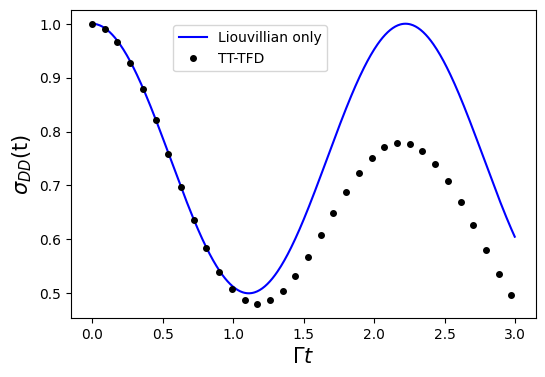

In [7]:
import scipy.linalg as LA

sigma_liou = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ), dtype=np.complex128)
time_arr = np.linspace(0,(pa.TIME_STEPS-1)*pa.DT,pa.TIME_STEPS)
sigma_liou[0] = np.array([1.0,0,0,0],dtype=np.complex128)
for i in range(1,pa.TIME_STEPS):
  sigma_liou[i] = LA.expm(-1j*LN0*pa.DT)@sigma_liou[i-1]

#read TT-TFD result and plot to compare
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,f"{data_dir}/TTTFD_Output/TFDSigma_")
plt.figure(figsize=(6,4))
plt.plot(time_arr, sigma_liou[:,0].real,'b-', label='Liouvillian only')
plt.plot(timeVec,  sigma_tt_tfd[:,0].real,'ko', markersize=4,markevery=15, label='TT-TFD')
plt.xlabel(r'$\Gamma t$',fontsize=15)
plt.ylabel(r'$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = (0.22, 0.8))
plt.show()

# Section 3

## Script S.3.1: Using QFlux To Obtain The Memory Kernel <a name="ScriptSpt3pt1"></a>

In [8]:
# 1. Get the propagator for memory kernel calculation

# The line below calculates all U elements with TT-TFD. The expected waiting time is 40 minutes on Google Colab.
# To save time, the results are already pre-computed and saved, and Is_run_dynamics is therefore set as False.
# The following code would still run normally. Please set Is_run_dynamics = True if one wishes to perform these calculations.

if Is_run_dynamics:
  print('==================now using tt-tfd to calculate propagator')
  timeVec,Gt = SBM.cal_propagator_tttfd()
  print('End of calculate propagator')

  #output the propagator
  wr.output_superoper_array(timeVec,Gt,f"{data_dir}/U_Output/U_")
else:
  timeVec,Gt = wr.read_superoper_array(pa.TIME_STEPS,f"{data_dir}/U_Output/U_")
  SBM.setup_propagator(Gt)

#2. volterra scheme: calculating the Memory kernel and output to the file
kernel = SBM.get_memory_kernel()
#output the kernel
wr.output_superoper_array(timeVec,kernel,f"{data_dir}/K_Output/K_")

Iteration: 1
	Iteration time: 0.24544000625610352
Iteration: 2
	Iteration time: 0.24489188194274902
Iteration: 3
	Iteration time: 0.2440018653869629
Iteration: 4
	Iteration time: 0.2489309310913086
Iteration: 5
	Iteration time: 0.2429802417755127
Iteration: 6
	Iteration time: 0.24277019500732422
Iteration: 7
	Iteration time: 0.24934887886047363
Iteration: 8
	Iteration time: 0.24285435676574707
Number of Iterations: 8 	Volterra time: 1.9621870517730713


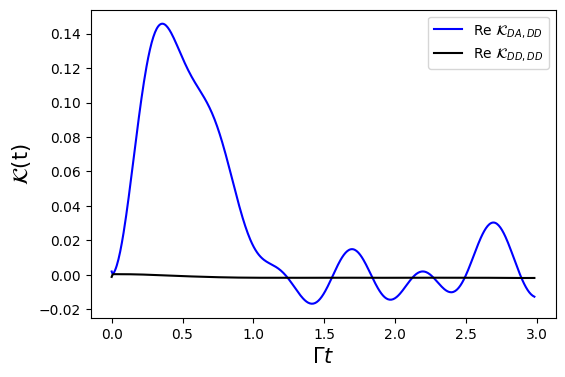

In [9]:
# Plot the kernel without the last two boundary points that have numerical errors

plt.figure(figsize=(6,4))
plt.plot(timeVec[:-2], kernel[:-2,1,0].real,'b-', label=r'Re $\mathcal{K}_{DA,DD}$')
plt.plot(timeVec[:-2], kernel[:-2,0,0].real,'k-', label=r'Re $\mathcal{K}_{DD,DD}$')
plt.xlabel(r'$\Gamma t$',fontsize=15)
plt.ylabel(r'$\mathcal{K}$(t)',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()

## Script S.3.2: The Propagator <a name="ScriptSpt3pt2"></a>

In [10]:
def cal_U_tt_tfd():

    U = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ, pa.DOF_E_SQ), dtype=np.complex128)

    # tt-tfd with initial state 0,1,2,3
    # initial state |0> means donor state |D>, |3> means acceptor state |A>
    # |1> is (|D> + |A>)/sqrt(2), |2> is (|D> + i|A>)/sqrt(2)
    print('========calculate the propagator, starting from 0 state========')
    t,U[:,:,0] = tfd.tt_tfd(0)
    print('========calculate the propagator, starting from 1 state========')
    t,U[:,:,1] = tfd.tt_tfd(1)
    print('========calculate the propagator, starting from 2 state========')
    t,U[:,:,2] = tfd.tt_tfd(2)
    print('========calculate the propagator, starting from 3 state========')
    t,U[:,:,3] = tfd.tt_tfd(3)
    print('========calculate the propagator done========')

    U_final = U.copy()

    # the coherence elements that start at initial state |D><A| and |A><D|
    # is the linear combination of above U results
    # |D><A| = |1><1| + i * |2><2| - 1/2 * (1 + i) * (|0><0| + |3><3|)
    U_final[:,:,1] = U[:,:,1] + 1.j * U[:,:,2] - 0.5 * (1. + 1.j) * (U[:,:,0] + U[:,:,3])

    # |A><D| = |1><1| - i * |2><2| - 1/2 * (1 - i) * (|0><0| + |3><3|)
    U_final[:,:,2] = U[:,:,1] - 1.j * U[:,:,2] - 0.5 * (1. - 1.j) * (U[:,:,0] + U[:,:,3])

    return t,U_final

# The line below calculates all U elements with TT-TFD. The expected waiting time is 40 minutes on Google Colab.
# To save time, the results are already pre-computed and saved, and Is_run_dynamics is therefore set as False.
# The following code would still run normally. Please set Is_run_dynamics = True if one wishes to perform these calculations.

if Is_run_dynamics:

    t, Gt = cal_U_tt_tfd()

    #output the propagator
    wr.output_superoper_array(t,Gt,f"{data_dir}/U_Output/U_")

## Script S.3.3: Projection-Free Inputs $ {\cal F}(\tau) $ And $ \dot{\cal F}(\tau) $ <a name="ScriptSpt3pt3"></a>

In [11]:
def cal_F():
    #read the propagator data from files
    timeVec,U = wr.read_superoper_array(pa.TIME_STEPS,f"{data_dir}/U_Output/U_")

    F = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ, pa.DOF_E_SQ), dtype=np.complex128)
    Fdot = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ, pa.DOF_E_SQ), dtype=np.complex128)

    for j in range(pa.DOF_E_SQ):
        for k in range(pa.DOF_E_SQ):
            # extracts real and imag parts of U element
            Ureal = U[:,j,k].copy().real
            Uimag = U[:,j,k].copy().imag

            # F = i * d/dt U so Re[F] = -1 * d/dt Im[U] and Im[F] = d/dt Re[U]
            Freal = -1. * np.gradient(Uimag.flatten(), pa.DT, edge_order = 2)
            Fimag = np.gradient(Ureal.flatten(), pa.DT, edge_order = 2)

            # Fdot = d/dt F so Re[Fdot] = d/dt Re[F] and Im[Fdot] = d/dt Im[F]
            Fdotreal = np.gradient(Freal, pa.DT)
            Fdotimag = np.gradient(Fimag, pa.DT)

            F[:,j,k] = Freal[:] + 1.j * Fimag[:]
            Fdot[:,j,k] = Fdotreal[:] + 1.j * Fdotimag[:]

    return timeVec,F,Fdot

timeVec,F,Fdot = cal_F()


## Script S.3.4: Linear Term $ g(t) $ <a name="ScriptSpt3pt4"></a>

In [12]:
linearTerm = 1.j * Fdot.copy() # first term of the linear part
for l in range(pa.TIME_STEPS):
    # subtract second term of linear part
    linearTerm[l,:,:] -= 1./pa.HBAR * F[l,:,:] @ LN0


## Script S.3.5: Function To Calculate Integral Via Trapezoidal Rule <a name="ScriptSpt3pt6"></a>

In [13]:
def CalculateIntegral(F, linearTerm, prevKernel, kernel):

    # time step loop starts at 1 because K is equal to linear part at t = 0
    for n in range(1, pa.TIME_STEPS):
        kernel[n,:,:] = 0.

        # f(a) and f(b) terms
        kernel[n,:,:] += 0.5 * pa.DT * F[n,:,:] @ kernel[0,:,:]
        kernel[n,:,:] += 0.5 * pa.DT * F[0,:,:] @ prevKernel[n,:,:]

        # sum of f(a + kh) term
        for c in range(1, n):
            # since a new (supposed-to-be-better) guess for the
            # kernel has been calculated for previous time steps,
            # can use it rather than prevKernel
            kernel[n,:,:] += pa.DT * F[n - c,:,:] @ kernel[c,:,:]

        # multiplies by i and adds the linear part
        kernel[n,:,:] = 1.j * kernel[n,:,:] + linearTerm[n,:,:]

    return kernel

## Script S.3.6: Memory Kernel - Volterra Algorithm <a name="ScriptSpt3pt5"></a>

In [14]:
START_TIME = time.time() # starts timing

# sets initial guess to the linear part
prevKernel = linearTerm.copy()
kernel = linearTerm.copy()

# loop for iterations
for numIter in tqdm(range(1, pa.MAX_ITERS + 1)):

    iterStartTime = time.time() # starts timing of iteration
    #print("Iteration:", numIter)

    # calculates kernel using prevKernel and trapezoidal rule
    kernel = CalculateIntegral(F, linearTerm, prevKernel, kernel)

    numConv = 0 # parameter used to check convergence of entire kernel
    for i in range(pa.DOF_E_SQ):
        for j in range(pa.DOF_E_SQ):
            for n in range(pa.TIME_STEPS):
                # if matrix element and time step of kernel is converged, adds 1
                if abs(kernel[n][i][j] - prevKernel[n][i][j]) <= pa.CONVERGENCE_PARAM:
                    numConv += 1

                # if at max iters, prints which elements and time steps did not
                # converge and prevKernel and kernel values
                elif numIter == pa.MAX_ITERS:
                    print("\tK time step and matrix element that didn't converge: %s, %s%s"%(n,i,j))

    #print("\tIteration time:", time.time() - iterStartTime)

    # enters if all times steps and matrix elements of kernel converged
    if numConv == pa.TIME_STEPS * pa.DOF_E_SQ * pa.DOF_E_SQ:
        # prints number of iterations and time necessary for convergence
        print("Number of Iterations:", numIter, "\tVolterra time:", time.time() - START_TIME)

        # prints memory kernel to files
        wr.output_superoper_array(timeVec,kernel,f"{data_dir}/K_Output/K_")

        break # exits the iteration loop

    # if not converged, stores kernel as prevKernel, zeros the kernel, and then
    # sets kernel at t = 0 to linear part
    prevKernel = kernel.copy()
    kernel = linearTerm.copy()

    # if max iters reached, prints lack of convergence
    if numIter == pa.MAX_ITERS:
        print("\tERROR: Did not converge for %s iterations"%pa.MAX_ITERS)
        print("\tVolterra time:", print(time.time() - START_TIME))

 23%|██▎       | 7/30 [00:02<00:06,  3.45it/s]

Number of Iterations: 8 	Volterra time: 2.0150890350341797


## Script S.3.7: Plot The Memory Kernel <a name="ScriptSpt3pt7"></a>

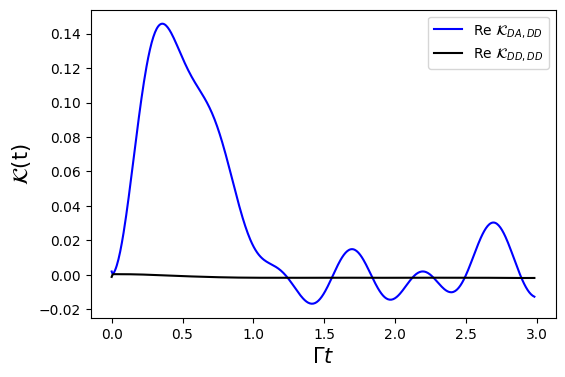

In [15]:
# Plot the kernel without the last two boundary points that have numerical errors
plt.figure(figsize=(6,4))
plt.plot(timeVec[:-2], kernel[:-2,1,0].real,'b-', label=r'Re $\mathcal{K}_{DA,DD}$')
plt.plot(timeVec[:-2], kernel[:-2,0,0].real,'k-', label=r'Re $\mathcal{K}_{DD,DD}$')
plt.xlabel(r'$\Gamma t$',fontsize=15)
plt.ylabel(r'$\mathcal{K}$(t)',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()

# Section 4

## Script S.4.1: Solve GQME Through QFlux <a name="ScriptSpt4pt1"></a>

In [16]:
sigma = SBM.solve_gqme(kernel, pa.MEM_TIME)

>>> Starting GQME propagation, memory time = 3.001659990105585
0
100
200
300
400


## Script S.4.2: GQME - Propagation Via RK4 Method <a name="ScriptSpt4pt2"></a>

In [17]:
def PropagateRK4(currentTime, memTime, kernel,
                 sigma_hold, sigma, DT=pa.DT):

    f_0 = Calculatef(currentTime, memTime,
                     kernel, sigma, sigma_hold)

    k_1 = sigma_hold + DT * f_0 / 2.
    f_1 = Calculatef(currentTime + DT / 2., memTime,
                     kernel, sigma, k_1)

    k_2 = sigma_hold + DT * f_1 /2.
    f_2 = Calculatef(currentTime + DT / 2., memTime,
                     kernel, sigma, k_2)

    k_3 = sigma_hold + DT * f_2
    f_3 = Calculatef(currentTime + DT, memTime,
                     kernel, sigma, k_3)

    sigma_hold += DT / 6. * (f_0 + 2. * f_1 + 2. * f_2 + f_3)

    return sigma_hold


## Script S.4.3: Calculating The Function $ f $ <a name="ScriptSpt4pt3"></a>

In [18]:
def Calculatef(currentTime, memTime, kernel, sigma_array, kVec, DT=pa.DT, HBAR=pa.HBAR, LN0=LN0):

    memTimeSteps = int(memTime / DT)
    currentTimeStep = int(currentTime / DT)

    f_t = np.zeros(kVec.shape, dtype=np.complex128)

    f_t -= 1.j / HBAR * LN0 @ kVec

    limit = memTimeSteps
    if currentTimeStep < (memTimeSteps - 1):
        limit = currentTimeStep
    for l in range(limit):
        f_t -= DT * kernel[l,:,:] @ sigma_array[currentTimeStep - l]

    return f_t


## Script S.4.4: GQME - Propagation Of The Density Matrix <a name="ScriptSpt4pt4"></a>

>>> Starting GQME propagation, memory time = 3.001659990105585


100%|██████████| 499/499 [00:00<00:00, 621.07it/s] 


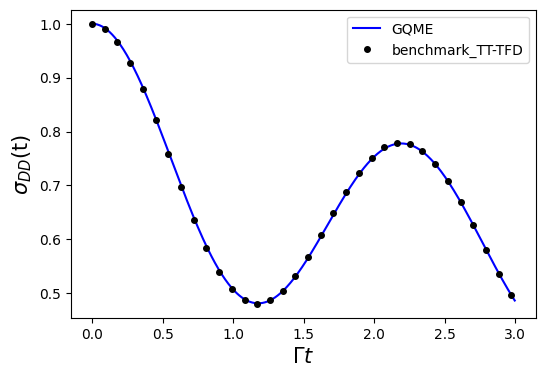

In [19]:
# read the memory kernel
timeVec, kernel = wr.read_superoper_array(pa.TIME_STEPS, f"{data_dir}/K_Output/K_")

# array for reduced density matrix elements
sigma = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ), dtype=np.complex128)

# array to hold copy of sigma
sigma_hold = np.zeros(pa.DOF_E_SQ, dtype = np.complex128)

# sets the initial state at Donor State
sigma[0,0] = 1.
sigma_hold[0] = 1.

# loop to propagate sigma

print(">>> Starting GQME propagation, memory time =", pa.MEM_TIME)
for l in tqdm(range(pa.TIME_STEPS - 1)): # it propagates to the final time step

    #if l%100==0: print(l)
    currentTime = l * pa.DT
    sigma_hold = PropagateRK4(currentTime, pa.MEM_TIME, kernel, sigma_hold, sigma)
    sigma[l + 1] = sigma_hold.copy()

# prints sigma to files
wr.output_operator_array(timeVec, sigma, f"{data_dir}/GQME_Output/Sigma_")

# Read the reference data and plot
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,f"{data_dir}/TTTFD_Output/TFDSigma_")
timeVec, sigma = wr.read_operator_array(pa.TIME_STEPS,f"{data_dir}/GQME_Output/Sigma_")

plt.figure(figsize=(6, 4))
plt.plot(timeVec, sigma[:,0].real,'b-', label='GQME')
plt.plot(timeVec, sigma_tt_tfd[:,0].real ,'ko', markersize=4, markevery=15, label='benchmark_TT-TFD')
plt.xlabel(r'$\Gamma t$',fontsize=15)
plt.ylabel(r'$\sigma_{DD}$(t)',fontsize=15)
plt.legend()
plt.show()

# Section 5

## Script S.5.1: Calculating $ {\cal{G}}(t) $ by solving the GQME <a name="ScriptSpt5pt1"></a>

In [20]:
# read the memory kernel
timeVec,kernel = wr.read_superoper_array(pa.TIME_STEPS, f"{data_dir}/K_Output/K_")

# array for Propagator superoperator elements
G_prop = np.zeros((pa.TIME_STEPS, pa.DOF_E_SQ, pa.DOF_E_SQ), dtype=np.complex128)

# time 0 propagator: identity superoperator
G_prop[0] = np.eye(pa.DOF_E_SQ)

# array to hold copy of G propagator
G_prop_hold = np.eye((pa.DOF_E_SQ), dtype=np.complex128)

# loop to propagate G_prop using GQME
print(">>> Starting GQME propagation, memory time =", pa.MEM_TIME)

for l in tqdm(range(pa.TIME_STEPS - 1)): # it propagates to the final time step

    #if l%100==0: print(l)
    currentTime = l * pa.DT
    G_prop_hold = PropagateRK4(currentTime, pa.MEM_TIME, kernel, G_prop_hold, G_prop)
    G_prop[l + 1] = G_prop_hold.copy()

>>> Starting GQME propagation, memory time = 3.001659990105585


100%|██████████| 499/499 [00:00<00:00, 586.82it/s] 


## Script S.5.2: QFlux one-Line solver for $ {\cal{G}}(t) $

In [21]:
G_prop = SBM.solve_gqme(kernel, pa.MEM_TIME, dtype='Propagator')

>>> Starting GQME propagation, memory time = 3.001659990105585
0
100
200
300
400


## Script S.5.3: Dilation Of The Non-Unitary Propagator <a name="ScriptSpt5pt2"></a>

In [22]:
def dilate(array):

  # Normalization factor of 1.1 to ensure contraction
  norm = LA.norm(array,2)*1.1
  array_new = array/norm

  ident = np.eye(array.shape[0])

  # Calculate the conjugate transpose of the G propagator
  fcon = (array_new.conjugate()).T

  # Calculate the defect matrix for dilation
  fdef = LA.sqrtm(ident - np.dot(fcon, array_new))

  # Calculate the defect matrix for the conjugate of the G propagator
  fcondef = LA.sqrtm(ident - np.dot(array_new, fcon))

  # Dilate the G propagator to create a unitary operator
  array_dilated = np.block([[array_new, fcondef], [fdef, -fcon]])

  return array_dilated, norm

## Script S.5.4: Using QFlux To Perform Quantum Algorithm For GQME <a name="ScriptSpt5pt3"></a>

Quantum simulation step 0
At time 0 with shots = 1024 no counts for 011
At time 1 with shots = 1024 no counts for 011
At time 2 with shots = 1024 no counts for 011
At time 3 with shots = 1024 no counts for 011
At time 4 with shots = 1024 no counts for 011
At time 5 with shots = 1024 no counts for 011
At time 6 with shots = 1024 no counts for 011
At time 7 with shots = 1024 no counts for 011
At time 8 with shots = 1024 no counts for 011
At time 9 with shots = 1024 no counts for 011
At time 10 with shots = 1024 no counts for 011
At time 11 with shots = 1024 no counts for 011
At time 12 with shots = 1024 no counts for 011
At time 13 with shots = 1024 no counts for 011
At time 14 with shots = 1024 no counts for 011
At time 15 with shots = 1024 no counts for 011
At time 16 with shots = 1024 no counts for 011
At time 19 with shots = 1024 no counts for 011
At time 21 with shots = 1024 no counts for 011
At time 22 with shots = 1024 no counts for 011
At time 23 with shots = 1024 no counts for 0

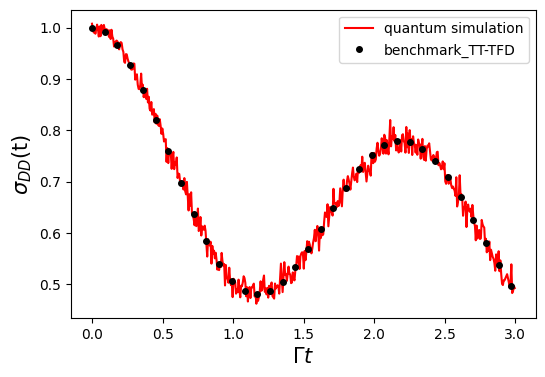

In [23]:
from qflux.open_systems.quantum_simulation import QubitDynamicsOS

qSBM = QubitDynamicsOS(rep='Density', Nsys = pa.DOF_E, Hsys = Hsys, rho0 = rho0)
qSBM.set_count_str(['000','011'])
qSBM.set_dilation_method('Sz-Nagy')

res_qc = qSBM.qc_simulation_vecdens(timeVec,Gprop=G_prop)
pop_qc = res_qc['data']

# visualizing
# Read the exact TT-TFD results
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,f"{data_dir}/TTTFD_Output/TFDSigma_")

# Plot the population of the donor and acceptor states
plt.figure(figsize=(6, 4))
plt.plot(timeVec, pop_qc[:,0], 'r-', label="quantum simulation")
plt.plot(timeVec, sigma_tt_tfd[:,0].real ,'ko', markersize=4, markevery=15, label='benchmark_TT-TFD')
plt.xlabel(r'$\Gamma t$',fontsize=15)
plt.ylabel(r'$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()

# Section 6

## Script S.6.1: Installing And Importing Qiskit Dependencies <a name="ScriptSpt6pt1"></a>

In [24]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator

## Script S.6.2: Qasm  Simulation For GQME <a name="ScriptSpt6pt2"></a>

In [25]:
# Create a dictionary to store the measurement results
result = {'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}

# Create lists to store the population for the acceptor and donor states
pop_accept = []
pop_donor = []

# initial state in the dilated space
rho0_dilated = np.concatenate((np.array([1 + 0j, 0, 0, 0]),np.zeros(pa.DOF_E_SQ)))

pbar = tqdm(range(pa.TIME_STEPS), desc="Running simulation", colour="green", leave=True)
for i in pbar:

    qr = QuantumRegister(3)  # Create a quantum register with 3 qubits
    cr = ClassicalRegister(3)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_dilated, qr)

    # Dilated propagator
    U_G, norm = dilate(G_prop[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)

    # Apply the unitary operator to the quantum circuit's qubits
    qc.unitary(U_G_op, qr)
    
    # Measure the qubits and store the results in the classical register
    qc.measure(qr, cr)

    # Run the Simulation and Plot the Results
    simulator = QasmSimulator()
    shots = 2000  # Number of shots
    job = simulator.run(qc,shots=shots)
    counts = job.result().get_counts(qc)

    # Update the result dictionary
    for x in counts:
        result[x] = counts[x]

    # Calculate the populations of donor and acceptor states from measurement probabilities
    pop_d = np.sqrt(result['000'] / shots) * norm  # Multiply by the normalization factor
    pop_a = np.sqrt(result['011'] / shots) * norm  # Multiply by the normalization factor

    #if i%100==0: print('at',i,'step','population',pop_d,pop_a)

    pop_donor.append(pop_d)  # Stacking the population for the donor state
    pop_accept.append(pop_a)  # Stacking the population for the acceptor state

    pbar.set_postfix(populationD=pop_d, populationA=pop_a)

pbar.close()

Running simulation: 100%|██████████| 500/500 [00:01<00:00, 399.58it/s, populationA=0.487, populationD=0.501]


## Script S.6.3: Visualizing The Results <a name="ScriptSpt6pt3"></a>

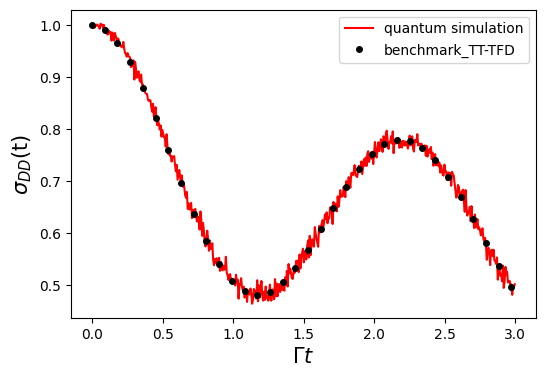

In [26]:
# Read the exact TT-TFD results
timeVec, sigma_tt_tfd = wr.read_operator_array(pa.TIME_STEPS,f"{data_dir}/TTTFD_Output/TFDSigma_")

# Plot the population of the donor and acceptor states
plt.figure(figsize=(6,4))
plt.plot(timeVec, pop_donor, 'r-', label="quantum simulation")
plt.plot(timeVec, sigma_tt_tfd[:,0].real ,'ko', markersize=4, markevery=15, label='benchmark_TT-TFD')
plt.xlabel(r'$\Gamma t$',fontsize=15)
plt.ylabel(r'$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()